# 基于PyTorch的水果图像分类

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
import pathlib
import PIL
import matplotlib.pyplot as plt

In [22]:
train_dir = pathlib.Path("D:\\大学\\人工智能导论\\课程论文\\archive\\fruits-360_dataset\\fruits-360\\Training")
test_dir = pathlib.Path("D:\\大学\\人工智能导论\\课程论文\\archive\\fruits-360_dataset\\fruits-360\\Test")

### 清点数据数量

In [23]:
Image_count = len(list(train_dir.glob('*/*.jpg')))
print(Image_count)

67692


#### 展示部分数据

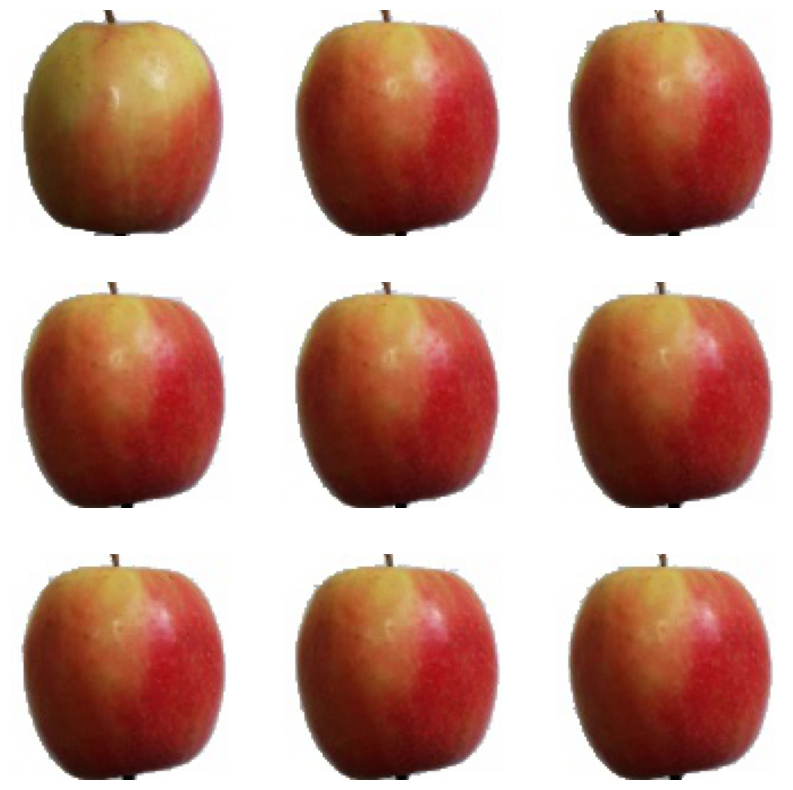

In [19]:
fruits = list(train_dir.glob("Apple Pink Lady/*.jpg"))

plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = PIL.Image.open(str(fruits[i]))
    plt.imshow(img)
    plt.axis('off')

plt.show()

In [24]:
# 定义图像的批处理大小、高度和宽度。

batch_size = 128
img_height = 100
img_width = 100

#### 数据预处理

In [43]:
# 定义转换器
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
])

# 加载数据集
train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)

# 定义数据加载器
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [52]:
class_names = train_data.classes
num_classes = len(class_names)

#### 定义模型结构

In [56]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 64 * 12 * 12)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

#### 初始化模型

In [57]:
model = CNN(num_classes=len(train_data.classes))

#### 定义损失函数和优化器

In [58]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### 训练和验证模型

In [60]:
# 训练模型

num_epochs = 60
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # 验证

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(test_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

Epoch [1/60], Train Loss: 0.6433, Train Acc: 0.8276, Val Loss: 0.4786, Val Acc: 0.8800
Epoch [2/60], Train Loss: 0.0475, Train Acc: 0.9857, Val Loss: 0.3692, Val Acc: 0.9195
Epoch [3/60], Train Loss: 0.0048, Train Acc: 0.9990, Val Loss: 0.3174, Val Acc: 0.9432
Epoch [4/60], Train Loss: 0.0341, Train Acc: 0.9907, Val Loss: 0.2545, Val Acc: 0.9647
Epoch [5/60], Train Loss: 0.0098, Train Acc: 0.9975, Val Loss: 0.5841, Val Acc: 0.8635
Epoch [6/60], Train Loss: 0.0211, Train Acc: 0.9941, Val Loss: 0.2350, Val Acc: 0.9642
Epoch [7/60], Train Loss: 0.0026, Train Acc: 0.9994, Val Loss: 0.2218, Val Acc: 0.9684
Epoch [8/60], Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.2216, Val Acc: 0.9726
Epoch [9/60], Train Loss: 0.0304, Train Acc: 0.9914, Val Loss: 0.3236, Val Acc: 0.9292
Epoch [10/60], Train Loss: 0.0071, Train Acc: 0.9981, Val Loss: 0.1953, Val Acc: 0.9741
Epoch [11/60], Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.1975, Val Acc: 0.9756
Epoch [12/60], Train Loss: 0.0000, Train 

#### 绘制精度曲线

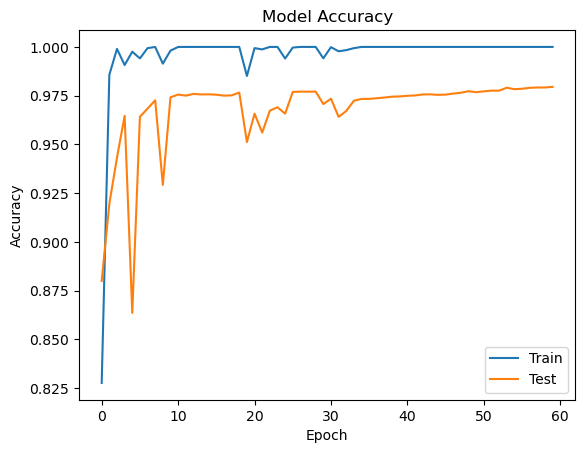

In [61]:
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Test')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##### 绘制损失曲线

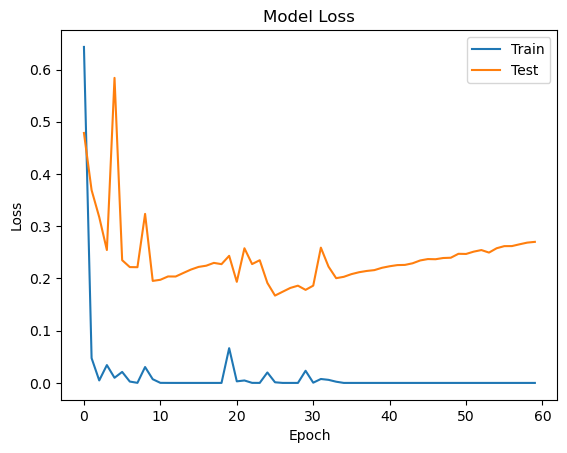

In [62]:
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Test')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 模型评估

In [63]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print('Accuracy:', accuracy)

Accuracy: 0.9795045839210155
